This notebook demonstrates how to load the appropriate data for different training experiments and their corresponding evaluations, once the data has been downloaded from Zenodo (see the `data_download.ipynb` notebook).

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Before loading the data, we define a few basic functions for visualization.

In [2]:
def plot_predictor_map(predictor, var_name, domain, time_index=0, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictor[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    
    data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictor set ({domain}) for time step {time_index}')
    plt.show()

def plot_orog_map(orog, domain, figsize=(8,8), cmap='terrain'):
    data_to_plot = orog['orog']
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if (domain == 'NZ') or (domain == 'SA'):
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Orography ({domain})')
    plt.show()

def plot_predictand_map(predictand, var_name, domain, time_index, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictand[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if (domain == 'NZ') or (domain == 'SA'):
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictand set ({domain}) for time step {time_index}')
    plt.show()

## Training Experiments

Thanks to the dataset structure across domains, loading the different experiments is quite straightforward.

In [3]:
domain = 'SA'
DATA_PATH = f'./Bench-data/{domain}/{domain}_domain'

Below, we can select which training experiment to load from the following options:

- ESD Pseudo Reality (`ESD_pseudo_reality`)
- Emulator (`Emulator_hist_future`)

Depending on the selection, the code will load the corresponding predictors and predictands for the chosen experiment.

In [4]:
training_experiment = 'Emulator_hist_future'

Based on the selected experiment, we choose the appropriate period and climate model (see the tables in the README for further details), as the NetCDF files are named according to these parameters.

In [5]:
# Set the period
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif (domain == 'NZ') or (domain == 'SA'):
    gcm_name = 'ACCESS-CM2'

For each training experiment, we obtain a set of predictors (including orography at the predictand’s resolution) and the corresponding predictand.

The predictors consist of 15 large-scale variables representing the state of the atmosphere, with a spatial resolution of approximately 150 km and daily temporal resolution.

In [6]:
predictor_filename = f'{DATA_PATH}/train/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
predictor = xr.open_dataset(predictor_filename)

In [7]:
if domain == 'SA':
    predictor = predictor.drop_vars('time_bnds')

In [8]:
print(predictor)

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 14600, lon: 16, lat: 16)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * lon      (lon) float64 128B 11.0 13.0 15.0 17.0 19.0 ... 35.0 37.0 39.0 41.0
  * lat      (lat) float64 128B -40.0 -38.0 -36.0 -34.0 ... -14.0 -12.0 -10.0
Data variables: (12/15)
    t_500    (time, lat, lon) float32 15MB ...
    t_700    (time, lat, lon) float32 15MB ...
    t_850    (time, lat, lon) float32 15MB ...
    u_500    (time, lat, lon) float32 15MB ...
    u_700    (time, lat, lon) float32 15MB ...
    u_850    (time, lat, lon) float32 15MB ...
    ...       ...
    z_500    (time, lat, lon) float32 15MB ...
    z_700    (time, lat, lon) float32 15MB ...
    z_850    (time, lat, lon) float32 15MB ...
    q_500    (time, lat, lon) float32 15MB ...
    q_700    (time, lat, lon) float32 15MB ...
    q_850    (time, lat, lon) float32 15MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interfa

The data can be easily visualized using Cartopy.

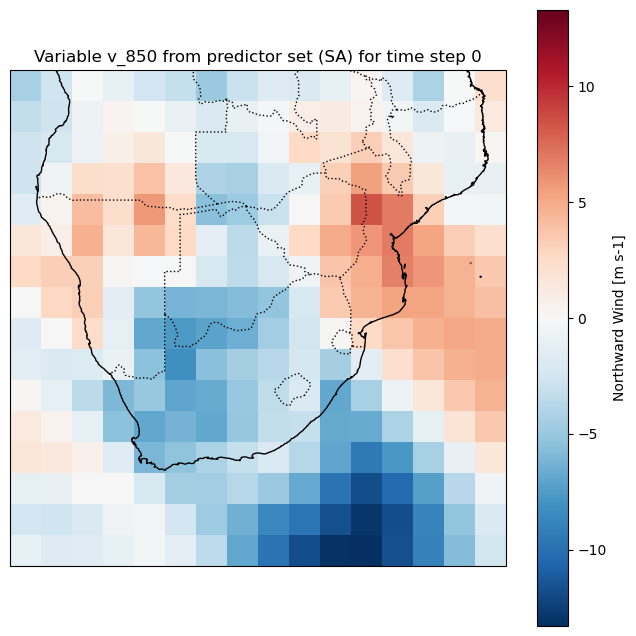

In [9]:
plot_predictor_map(predictor=predictor, var_name='v_850', domain=domain, cmap='RdBu_r')

We can also include orography as a predictor (co-variable) at the same spatial resolution as the target (~11 km).

In [10]:
if domain != 'SA':

    orog_path =  f'{DATA_PATH}/train/{training_experiment}/predictors/Static_fields.nc'
    orog = xr.open_dataset(orog_path)
    
    if domain == 'NZ':
        orog = orog[['orog']]

In [11]:
if domain != 'SA':
    print(orog)

In [12]:
if domain != 'SA':
    plot_orog_map(orog=orog, domain=domain)

Finally, we can load the predictand, which is the data used as the target. The same NetCDF file contains both variables considered as predictands in this benchmark: daily maximum temperature (tasmax) and precipitation (pr).

In [13]:
predictand_filename = f'{DATA_PATH}/train/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
predictand = xr.open_dataset(predictand_filename)

In [14]:
if domain == 'SA':
    predictand = predictand.drop_vars(['time_bnds', 'lon_bnds', 'lat_bnds', 'crs'])

In [15]:
print(predictand)

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 14600, lon: 128, lat: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * lon      (lon) float32 512B 20.5 20.6 20.7 20.8 20.9 ... 32.9 33.0 33.1 33.2
  * lat      (lat) float32 512B -34.7 -34.6 -34.5 -34.4 ... -22.2 -22.1 -22.0
Data variables:
    pr       (time, lat, lon) float64 2GB ...
    tasmax   (time, lat, lon) float32 957MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Thu Sep 25 09:29:15 2025: cdo mergetime pr_tasmax_c...
    source:               CSIRO conformal-cubic model. Input file: ccam_8.km....
    Conventions:          CF-1.11
    title:                CCAM simulation data
    il:                   192
    ...                   ...
    ateb_ac_deltat:       1.0
    ateb_ac_heatcap:      10.0
    ateb_acfactor:        2.0
    ateb_alpha:           1.0
    ateb_lwintmeth:       2
    ateb_

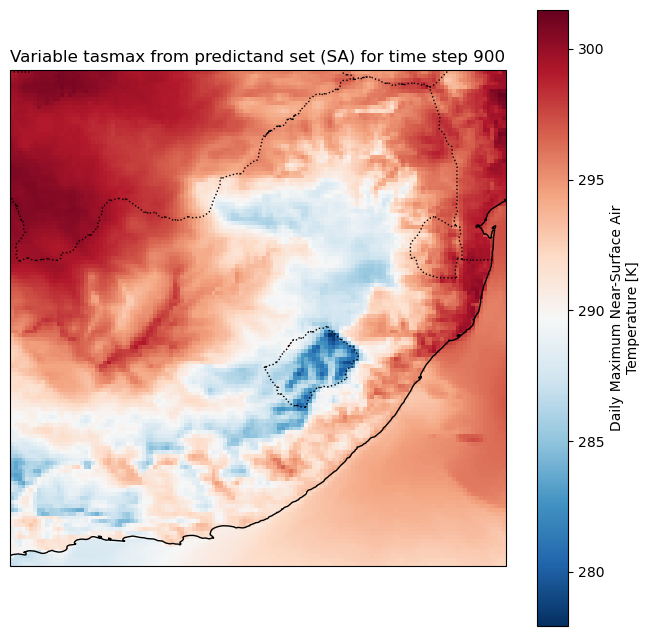

In [211]:
plot_predictand_map(predictand=predictand, var_name='tasmax', time_index=900, domain=domain, cmap='RdBu_r')

Unlike the NZ domain, for the ALPS domain the predictand simulations are provided on a curvilinear Lambert projection, which affects the visualization in Cartopy. However, the data can still be used for model training without additional processing, as it remains a square array. This ensures that models can be trained in the same way regardless of the domain.

In the following cell, we visualize the raw NumPy array for the ALPS domain.

In [212]:
if domain == 'ALPS':
    predictand_tasmax_array = predictand['tasmax'].values
    plt.imshow(predictand_tasmax_array[0, :], origin='lower')
    plt.colorbar()
    plt.show()

## Evaluation Experiments

Similarly to the training data, the evaluation data for the different experiments can be loaded in the same format with ease. We follow the same naming convention for evaluation experiments as provided in the tables of the README. In the following cell we specify which evaluation experiment to load.

In [213]:
evaluation_experiment = 'Extrapolation_perfect_hard'

Below, we define the data to be loaded for each evaluation experiment.

In [214]:
# Define experiment settings
evaluation_experiment_settings = {
    "ESD_pseudo_reality": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_imperfect": ("mid_end_century", "imperfect", True),
    },
    "Emulator_hist_future": {
        "PP_cross_validation": ("historical", "perfect", True),
        "Imperfect_cross_validation": ("historical", "imperfect", True),
        "Extrapolation_perfect": ("mid_end_century", "perfect", True),
        "Extrapolation_perfect_hard": ("mid_end_century", "perfect", False),
        "Extrapolation_imperfect_hard": ("mid_end_century", "imperfect", False),
    },
}

# Get settings for the chosen experiments
period, mode, same_gcm_as_train = evaluation_experiment_settings[training_experiment][evaluation_experiment]

In [215]:
# Map periods to dates
period_dates = {
    "historical": "1981-2000",
    "mid_century": "2041-2060",
    "end_century": "2080-2099",
    "mid_end_century": ["2041-2060", "2080-2099"],
}

period_date = period_dates[period]

In [216]:
# GCM selection by domain and training setup
gcm_train = {"NZ": "ACCESS-CM2", "ALPS": "CNRM-CM5", "SA": "ACCESS-CM2"}
gcm_eval = {"NZ": "EC-Earth3", "ALPS": "MPI-ESM-LR", "SA": "NorESM2-MM"}

if same_gcm_as_train:
    gcm_name = gcm_train[domain]
else:
    gcm_name = gcm_eval[domain]

With the option set, we can proceed to load the corresponding predictor data.

In [217]:
if period == 'mid_end_century':
    predictor_evaluation_filename_mid_century = f'{DATA_PATH}/test/mid_century/predictors/{mode}/{gcm_name}_2041-2060.nc'
    predictor_evaluation_mid = xr.open_dataset(predictor_evaluation_filename_mid_century)
    
    predictor_evaluation_filename_end_century = f'{DATA_PATH}/test/end_century/predictors/{mode}/{gcm_name}_2080-2099.nc'
    predictor_evaluation_end = xr.open_dataset(predictor_evaluation_filename_end_century)

    predictor_evaluation = xr.merge([predictor_evaluation_mid, predictor_evaluation_end])
else:
    predictor_evaluation_filename = f'{DATA_PATH}/test/{period}/predictors/{mode}/{gcm_name}_{period_date}.nc'
    predictor_evaluation = xr.open_dataset(predictor_evaluation_filename)

In [218]:
if 'time_bnds' in list(predictor_evaluation.data_vars):
    predictor_evaluation = predictor_evaluation.drop_vars('time_bnds')

In [219]:
print(predictor_evaluation)

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 14600, lon: 16, lat: 16)
Coordinates:
  * time     (time) object 117kB 2041-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lon      (lon) float64 128B 11.0 13.0 15.0 17.0 19.0 ... 35.0 37.0 39.0 41.0
  * lat      (lat) float64 128B -40.0 -38.0 -36.0 -34.0 ... -14.0 -12.0 -10.0
Data variables: (12/15)
    t_500    (time, lat, lon) float32 15MB 260.5 260.5 260.6 ... 272.5 272.3
    t_700    (time, lat, lon) float32 15MB 275.0 275.2 275.5 ... 284.6 284.7
    t_850    (time, lat, lon) float32 15MB 282.0 282.1 282.3 ... 295.0 294.6
    u_500    (time, lat, lon) float32 15MB 25.16 23.74 21.53 ... 1.55 2.432
    u_700    (time, lat, lon) float32 15MB 18.57 17.37 15.7 ... 3.086 4.058
    u_850    (time, lat, lon) float32 15MB 15.37 14.46 12.65 ... 0.05437 1.154
    ...       ...
    z_500    (time, lat, lon) float32 15MB 5.713e+03 5.715e+03 ... 5.932e+03
    z_700    (time, lat, lon) float32 15MB 3.068e+03 3.069e+03 ... 3.177e+03
    z_850    (time,

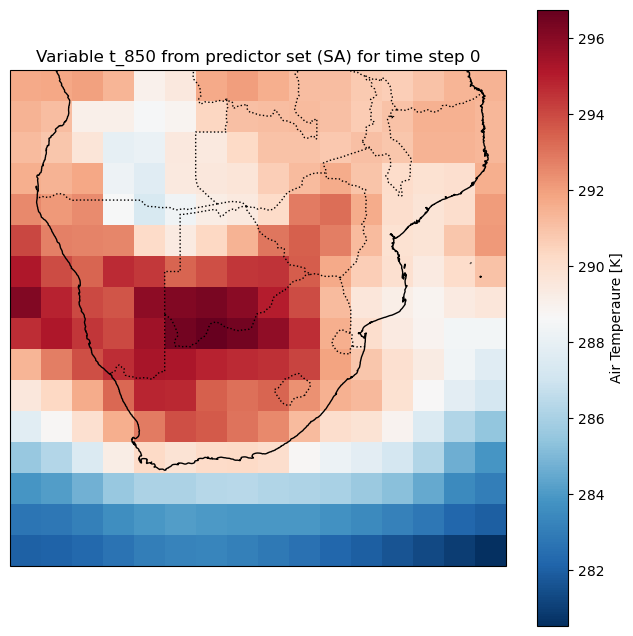

In [220]:
plot_predictor_map(predictor=predictor_evaluation, var_name='t_850', domain=domain, cmap='RdBu_r')